# Project 1: Mining information from Text Data 
<hr>

## Task 1: Finding Similar Items

Randomly select 1000 abstracts from the whole dataset. Find the similar items using pairwise Jaccard similarities, MinHash and LSH (vectorized versions) .

1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?

 
 

<hr>

#### 1. Compare the performance in time and the results for k-shingles = 3, 5 and 10, for the three methods and similarity thresholds s=0.1 and 0.2. Use 50 hashing functions. Comment your results.

0. Import libraries

In [1]:
from urllib.request import urlopen
from io import BytesIO
from time import time

import pandas as pd
import gzip
import re
import binascii
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

1. Download the data files

In [2]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'   # url where the file is stored
filename = 'anthology+abstracts.bib'                           # bib filename
folder   = 'data'                                              # folder name
minimum = 200                                                  # minimum number of words in the abtract to be considered 

# Create the path to store the files
os.makedirs(folder, exist_ok=True)

file = folder + '/' + filename

# Download the file if it doesn't exist locally
if(not os.path.exists(file)):
  print("Downloading " + url + " to /" + folder + "..." )
  with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(file, 'wb') as f:
        f.write(fb.read())
else:
  print("File " + filename + " already available in folder /" + folder)        


File anthology+abstracts.bib already available in folder /data


2. Load data and make some preprocessing

In [3]:
# Read and process data
abstracts = []
titles = []
ids = []

with open(file, 'r',errors='ignore') as f:
    for line in f:    
      if '@proceedings{' in line:                                 # key found
        line = re.sub('@proceedings{', '', line)                  # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line  
      if '@inproceedings{' in line:                               # key found
        line = re.sub('@inproceedings{', '', line)                # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line            
      if ' title = "' in line:                                    # title found
        line = re.sub(' title = "', '', line)                     # remove "title ="
        title = line
      if 'abstract = "' in line:                                  # abstract found
        if len(re.findall('[a-zA-Z]', line)) > .2*len(line):      # ignore non latin
          if len(line) > minimum:                                 # ignore abstracts with less than minimum words (200)
            line = re.sub(' +', ' ', line)                        # remove double spaces
            line = re.sub(' abstract = ', '', line)               # remove "abstract =" 
            line = re.sub('"|\n|,', '', line)                     # remove some other characters  
            line = line.lower()                                   # transform to lower letters             
            abstracts.append(line)
            titles.append(title)
            ids.append(id)

print('Number of abstracts:', len(abstracts))
print('Number of titles:', len(titles))
print('Number of ids:', len(ids))
print('\nAbstract:', abstracts[0])
print('\nTitle:', titles[0])
print('ID:', ids[0])

Number of abstracts: 30115
Number of titles: 30115
Number of ids: 30115

Abstract: offensive language detection (old) has received increasing attention due to its societal impact. recent work shows that bidirectional transformer based methods obtain impressive performance on old. however such methods usually rely on large-scale well-labeled old datasets for model training. to address the issue of data/label scarcity in old in this paper we propose a simple yet effective domain adaptation approach to train bidirectional transformers. our approach introduces domain adaptation (da) training procedures to albert such that it can effectively exploit auxiliary data from source domains to improve the old performance in a target domain. experimental results on benchmark datasets show that our approach albert (da) obtains the state-of-the-art performance in most cases. particularly our approach significantly benefits underrepresented and under-performing classes with a significant improvement o

In [4]:
# Creating a dataframe with ID, abstract and title
data_tuples = list(zip(ids, titles, abstracts))
data = pd.DataFrame(data_tuples, columns=['ID', 'title', 'abstract'])

In [5]:
data

,ID,title,abstract
0,singh-li-2021-exploiting,Exploiting Auxiliary Data for Offensive Lan...,offensive language detection (old) has receive...
1,hahn-etal-2021-modeling,Modeling Profanity and Hate Speech in Socia...,hate speech and profanity detection suffer fro...
2,caselli-etal-2021-hatebert,{H}ate{BERT}: Retraining {BERT} for Abusive...,we introduce hatebert a re-trained bert model ...
3,kirk-etal-2021-memes,Memes in the Wild: Assessing the Generaliza...,hateful memes pose a unique challenge for curr...
4,kivlichan-etal-2021-measuring,Measuring and Improving Model-Moderator Col...,content moderation is often performed by a col...
...,...,...,...
30110,raphael-1963-computer,A computer representation for semantic info...,this paper deals with the problem of represent...
30111,tabory-1963-specifications,Specifications for generative grammars used...,it becomes more and more evident that successf...
30112,tosh-1963-collecting,Collecting linguistic data for the grammar ...,establishing the grammatical description of a ...
30113,wahlgren-1963-derivational,Derivational suffixes in {R}ussian general ...,a grammar based upon a conventional morphemic ...


3. Randomly select 1000 abstracts and save them to a file

In [6]:
# Randomly select 1000 rows
data = data.sample(n=1000, random_state=1)
# Reset index
data = data.reset_index(drop=True)
# Get abstracts
abstracts = data['abstract'].tolist()

# save abstracts to a file for other tasks
os.makedirs(folder, exist_ok=True)  
data.to_csv('./data/abstracts.csv')

4. Define main functions

In [7]:
" Returns the k hasshed shingles of a"
def get_shingles(a, k):
    L = len(a)
    shingles = set()                                   # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):                              
        shingle = a[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8'))  # hash the shingle to a 32-bit integer
        shingles.add(crc)    
    return shingles

In [8]:
" Returns the jaccard similarity score of two sets (x y) "
def jaccard_similarity_score(x, y):
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [9]:
" Minhashing "
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [10]:
" Locality Sensitive Hashing "
def LSH(signatures, bands, rows, Ab, Bb, nextPrime, maxShingleID):
    numItems = signatures.shape[1]
    signBands = np.array_split(signatures, bands, axis=0)
    candidates = set()
    for nb in range(bands):
        hashTable = {}
        for ni in range(numItems):
            item = signBands[nb][:,ni]
            hash = (np.dot(Ab[nb,:], item) + Bb[nb]) % nextPrime % maxShingleID
            if hash not in hashTable:
                hashTable[hash] = [ni]
            else:
                hashTable[hash].append(ni)
        for _,items in hashTable.items():
            if len(items) > 1:
                L = len(items)
                for i in range(L-1):
                    for j in range(i+1, L):
                        cand = [items[i], items[j]]
                        np.sort(cand)
                        candidates.add(tuple(cand))
    return candidates

In [11]:
" Plot results "
def plot_results(title, times, num_of_similar_items, objects):
    plt.rcParams["figure.figsize"] = (19,6)

    plt.subplot(1,2,1)
    objects = objects
    y_pos = np.arange(len(objects))
    metric = times
    plt.barh(y_pos, metric, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.title(title +' (time)')

    plt.subplot(1,2,2)
    y_pos = np.arange(len(objects))
    metric = num_of_similar_items
    plt.yticks(y_pos, objects)
    plt.barh(y_pos, metric, align='center', alpha=0.5)    
    plt.title(title + ' (items)')

    plt.show()

4. Jaccard Similarity: **(CAUTION: This process takes long execution time!!)**

In [12]:
# Get candidate pairs using naive approach

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    for k in k_shingles:
        candidates = []
        t = time()
        for pair in itertools.combinations(abstracts,2):
            js = jaccard_similarity_score(get_shingles(pair[0], k),get_shingles(pair[1], k))    
            if js > s:
                candidates.append(pair)
        t1 = time()-t
        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)
        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 494717
Took 528.1854770183563 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 6758
Took 550.4760663509369 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 2
Took 538.7941002845764 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 366030
Took 519.6210227012634 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 2
Took 526.2527525424957 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 0
Took 530.7014076709747 seconds



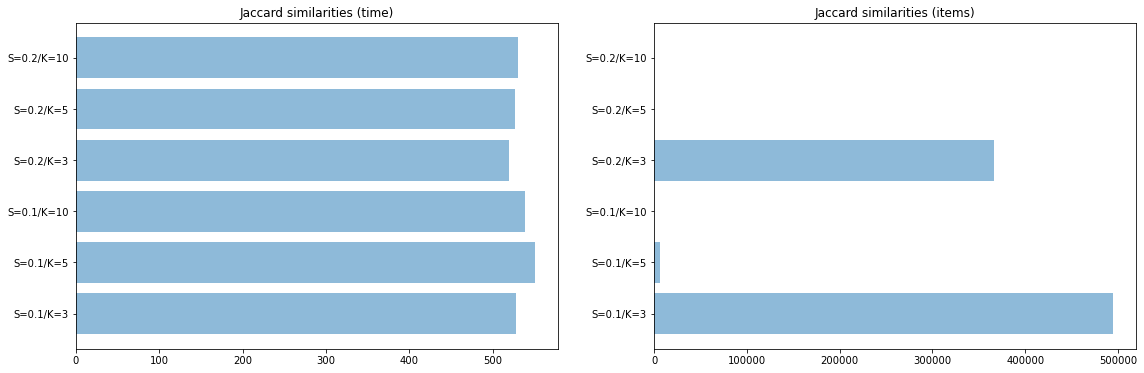

In [13]:
objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
plot_results('Jaccard similarities', times, num_of_similar_items, objects)

5. MinHashing

In [14]:
# get candidate pairs using MinHashing
bands = 10         # number of bands
rows = 5           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

similarity_threshold = [0.1, 0.2]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for s in similarity_threshold:
    
    for k in k_shingles:
        
        signatures = []  # signatures for all files
        
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)
            
        Nfiles = len(signatures)
        
        t = time()
        candidates = []
        for i in range(Nfiles):
            for j in range(i+1, Nfiles):
                Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                    candidates.append((i,j))
        t1 = time() - t

        print('Similarity threshold:', s)        
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))  
        if(len(candidates) < 11):
            print(candidates)
        print("Took {} seconds\n".format(t1))     
        
        num_of_similar_items.append(len(candidates))
        times.append(t1)        

        

Similarity threshold: 0.1
K_Shingles: 3
Num of candidates found: 484480
Took 5.322879791259766 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of candidates found: 64557
Took 5.329484701156616 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of candidates found: 118
Took 5.209201097488403 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of candidates found: 356944
Took 5.252366065979004 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of candidates found: 440
Took 5.249383449554443 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of candidates found: 0
[]
Took 5.216473817825317 seconds



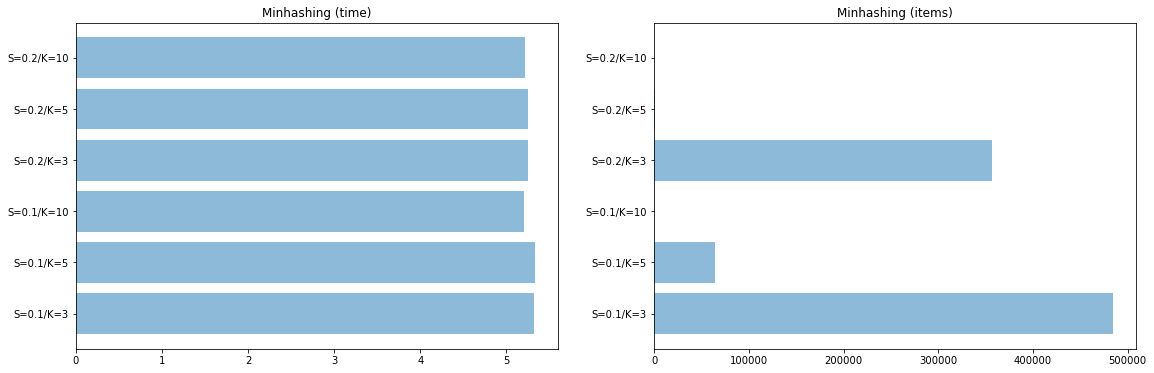

In [15]:
objects = ('S=0.1/K=3', 'S=0.1/K=5', 'S=0.1/K=10', 'S=0.2/K=3', 'S=0.2/K=5', 'S=0.2/K=10')
plot_results('Minhashing', times, num_of_similar_items, objects)

6. Locality Sensitive Hashing (LSH)

In [16]:
# get candidate pairs using Local Sensitive Hashing (LSH) with thresholds 0.1 and 0.2
list = [(100,2),(125,3)]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []

for (bands,rows) in list:
    nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

    maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
    nextPrime = 4294967311  # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows and the number of bands 
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('K_Shingles:', k)        
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

K_Shingles: 3
Num of candidates found: 486744
Took 13.518043279647827 seconds

K_Shingles: 5
Num of candidates found: 150076
Took 1.5013930797576904 seconds

K_Shingles: 10
Num of candidates found: 2015
Took 0.4529402256011963 seconds

K_Shingles: 3
Num of candidates found: 345796
Took 4.212810516357422 seconds

K_Shingles: 5
Num of candidates found: 23820
Took 0.8201999664306641 seconds

K_Shingles: 10
Num of candidates found: 27
Took 0.5267825126647949 seconds



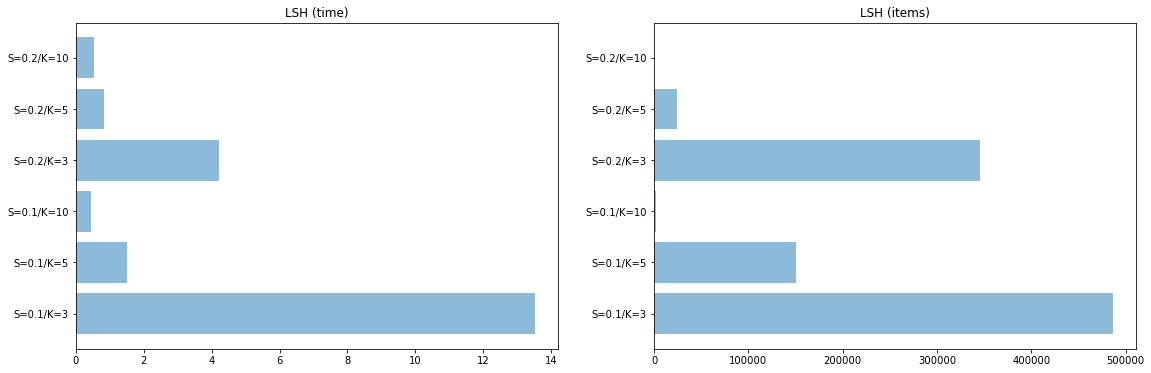

In [17]:
plot_results('LSH', times, num_of_similar_items, objects)

200 0.1
375 0.2
180 0.2554364774645177


Text(0.5, 1.0, 'Similarity threshold = 0.25')

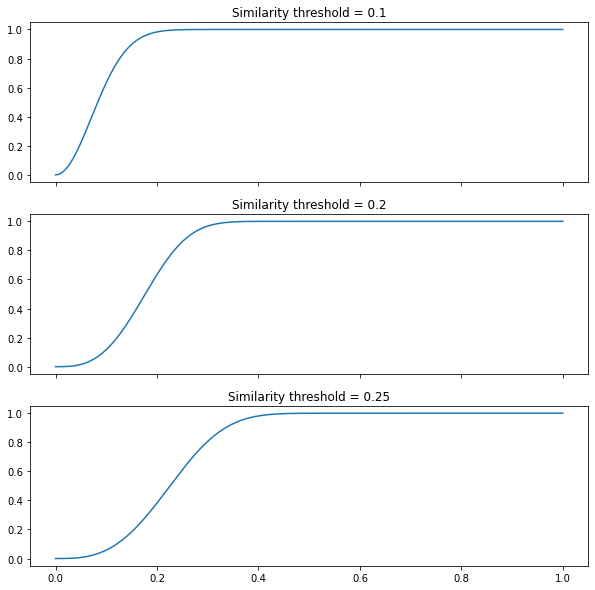

In [18]:
# Plot the selected number of bands and rows to obtain the desired threshold

# s = 0.1
b1 = 100
r1 = 2
print(b1*r1, (1.0/b1)**(1.0/r1))

# s = 0.2
b2 = 125
r2 = 3
print(b2*r2, (1.0/b2)**(1.0/r2))

# s = 0.25
b3 = 60
r3 = 3
print(b3*r3, (1.0/b3)**(1.0/r3))

t = np.linspace(0,1,1000)  # just lots of points between 0 and 1 for plotting
p1 = 1 - np.power((1 - np.power(t, r1)), b1)  # Formula: p = 1 - (1 - t^r)^b 
p2 = 1 - np.power((1 - np.power(t, r2)), b2)  # Formula: p = 1 - (1 - t^r)^b 
p3 = 1 - np.power((1 - np.power(t, r3)), b3)  # Formula: p = 1 - (1 - t^r)^b 

plt.rcParams["figure.figsize"] = (10,10)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(t,p1)
axs[0].set_title('Similarity threshold = 0.1')
axs[1].plot(t,p2)
axs[1].set_title('Similarity threshold = 0.2')
axs[2].plot(t,p3)
axs[2].set_title('Similarity threshold = 0.25')

7. Comments

With these exexcutions we have seen that MinHash and LSH techniques provide an estimate of Jaccard Similarity Coefficient with much fewer computations.

LSH performs much faster than the other techniques but also includes more false positives and false negatives.

<hr>

#### 2. Compare the results obtained for MinHash and LSH for different similarity thresholds s = 0.1, 0.2 and 0.25 and 50, 100 and 200 hashing functions. Comment your results.

Minhashing

In [19]:
# get candidate pairs using MinHashing
# set global parameters to process the whole dataset
list = [(10,5),(10,10),(20,10)]
similarity_threshold = [0.1, 0.2, 0.25]
k_shingles = [3,5,10]

labels = []
num_of_similar_items = []
times = []   

for (bands,rows) in list:
    nsig = bands*rows           # number of elements in signature, or the number of different random hash functions
    maxShingleID = 2**32-1      # record the maximum shingle ID that we assigned
    nextPrime = 4294967311      # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

    for s in similarity_threshold:            
        for k in k_shingles:
            signatures = []  # signatures for all files
        
            for a in abstracts:
                shingles = get_shingles(a, k)
                signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
                signatures.append(signature)
            
            Nfiles = len(signatures)
        
            t = time()
            candidates = []
            for i in range(Nfiles):
                for j in range(i+1, Nfiles):
                    Jsim = np.mean(signatures[i] == signatures[j])     # average number of similar items in 
                    if Jsim >= s:                                      # two vectors, equivalent to Jaccard 
                        candidates.append((i,j))
            t1 = time() - t

            print('Similarity threshold:', s)        
            print('K_Shingles:', k)
            print('Num of hashing functions:', nsig)        
            print('Num of candidates found:', len(candidates))             
            labels.append('s=' + str(s) + '/' + 'K=' + str(k) + '/H=' + str(nsig))
            print("Took {} seconds\n".format(t1))     

            num_of_similar_items.append(len(candidates))
            times.append(t1)        

Similarity threshold: 0.1
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 486171
Took 5.367499828338623 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 74102
Took 5.228292226791382 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 198
Took 5.245673418045044 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 341397
Took 5.326272487640381 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of hashing functions: 50
Num of candidates found: 588
Took 5.243901491165161 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of hashing functions: 50
Num of candidates found: 1
Took 5.202789783477783 seconds

Similarity threshold: 0.25
K_Shingles: 3
Num of hashing functions: 50
Num of candidates found: 179840
Took 5.240648984909058 seconds

Similarity threshold: 0.25
K_Shingles: 5
Num of hashing functions: 50
Num of c

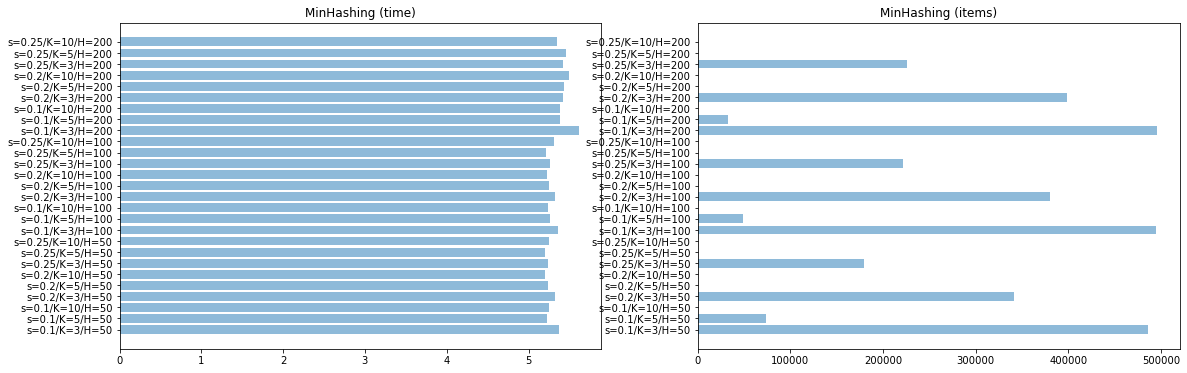

In [20]:
plot_results('MinHashing', times, num_of_similar_items, labels)

Local Sensitive Hashing (LSH)

In [21]:
list = [(100,2),(125,3),(60,3)]
k_shingles = [3, 5, 10]

num_of_similar_items = []
times = []
labels = []

for (bands,rows) in list:
    nsig = bands*rows           # number of elements in signature, or the number of different random hash functions
    s = (1.0/bands)**(1.0/rows) # calculate the threshold
    maxShingleID = 2**32-1      # record the maximum shingle ID that we assigned
    nextPrime = 4294967311      # next prime number after maxShingleID

    A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
    B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)


    for k in k_shingles:
        signatures = []  # signatures for all files
        for a in abstracts:
            shingles = get_shingles(a, k)
            signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)
            signatures.append(signature)

        # prepare data for LSH
        A2 = np.random.randint(0, nextPrime/2, size=(bands, rows),dtype=np.int64)  # now we need a vector of A parameters for each band
        B2 = np.random.randint(0, nextPrime/2, size=(bands, ),dtype=np.int64)
        signatures = np.array(signatures).T  # LSH needs a matrix of signatures, not a list of vectors

        #s = 0.95  # NO similarity threshold, why? The threshold is implicit when we choose the number of rows (r) and the number of bands (b)
        Nfiles = signatures.shape[1]  # number of different files
        t = time()
        candidates = LSH(signatures, bands, rows, A2, B2, nextPrime, maxShingleID)
        t1 = time() - t
     
        print('Similarity threshold:', s) 
        print('K_Shingles:', k)  
        print('Num of hashing functions:', nsig)       
        print('Num of candidates found:', len(candidates))    
        print("Took {} seconds\n".format(t1))     
        labels.append('s=' + str("{:0.2f}".format(s)) + '/' + 'K=' + str(k) + '/H=' + str(nsig))
        num_of_similar_items.append(len(candidates))
        times.append(t1)  

Similarity threshold: 0.1
K_Shingles: 3
Num of hashing functions: 200
Num of candidates found: 482335
Took 13.373099327087402 seconds

Similarity threshold: 0.1
K_Shingles: 5
Num of hashing functions: 200
Num of candidates found: 156100
Took 1.5433595180511475 seconds

Similarity threshold: 0.1
K_Shingles: 10
Num of hashing functions: 200
Num of candidates found: 4245
Took 0.45966672897338867 seconds

Similarity threshold: 0.2
K_Shingles: 3
Num of hashing functions: 375
Num of candidates found: 383226
Took 5.065078496932983 seconds

Similarity threshold: 0.2
K_Shingles: 5
Num of hashing functions: 375
Num of candidates found: 11434
Took 0.6698493957519531 seconds

Similarity threshold: 0.2
K_Shingles: 10
Num of hashing functions: 375
Num of candidates found: 45
Took 0.5199031829833984 seconds

Similarity threshold: 0.2554364774645177
K_Shingles: 3
Num of hashing functions: 180
Num of candidates found: 270735
Took 2.56203556060791 seconds

Similarity threshold: 0.2554364774645177
K_Shin

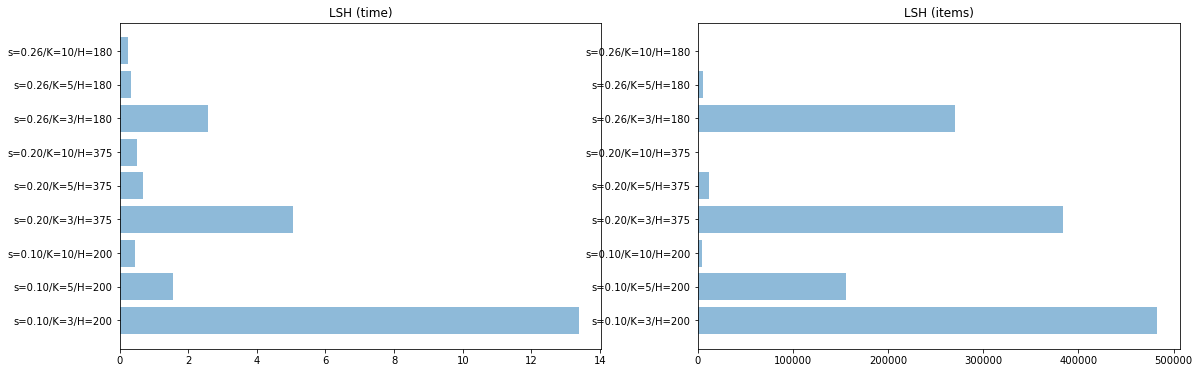

In [22]:
plot_results('LSH', times, num_of_similar_items, labels)

<hr>

#### 3. For MinHashing using 100 hashing functions and s = 0.1 and 0.2, find the Jaccard distances (1-Jaccard similarity) for all possible pairs. Use the obtained values within a k-NN algorithm, and for k=1,3 and, 5 identify the clusters with similar abstracts for each s. Describe the obtained clusters, are they different?. Select randomly at least 5 abstracts per cluster, upon visual inspection, what are the main topics?